A mass $m$ on a spring with stiffness $k$ driven by a constant rate $r$ on a rougn surface (sliding friction $\mu$, static friction $\nu$).  

Differential equation of motion $t > t_0$:

$\ddot{x} = \dfrac{k(rt-x) - 2 \gamma \dot{x} \mp f}{m}$, where sign is determined by motion direction and $f$ is sliding friction $\mu m g$.

Before the moment $t = t_0 = \nu m g / r$ we have $x(t)=0$, $\dot{x}(t)=0$ and $f = - krt$.

### Importing nessesary modules.

In [88]:
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

### Creating class of experimental setup.

In [89]:
g = 9.81 # m/s2

class setup():
### initialising independent and dependent parameters of the system
    def __init__(self, **kwargs):
        self.m = kwargs['m'] # kg
        self.k = kwargs['k'] # N/m
        self.r = kwargs['r'] # m/s
        self.mu = kwargs['mu']
        self.nu = kwargs['nu']
        self.gamma = kwargs['gamma'] # N / m/s
        # just esteemating the natural frequency of the spring oscillator
        self.omega0 = np.sqrt(self.k/self.m) # 1/s
        # drag starts when spring is stronger than static friction
        self.t0 = self.nu*self.m*g/self.k/self.r # s

        print('------------setup calculated parameters------------')
        print(f'drag start = {self.t0} s, natural frequency = {self.omega0} 1/s')

### integrating the differencial equatian of motion with Taylor series expansion up to second order derivatives
    def __integrate(self, t_stop, timeFinement = 100):
        dt = 1/self.omega0/timeFinement
        
        print('------------integrating parameters------------')
        print(f't_stop = {t_stop} s, timeFinement = {timeFinement}, dt = {dt} s')

        if t_stop - self.t0 < dt:
            # just giving zeros, the static friction holds the mass
            tt = np.arange(0, t_stop, dt)
            xx = np.zeros_like(tt)
            return (tt, xx, vv, self.k*self.r*tt)
        
        else:
            # prepare the grid, velocity grid is needed because the mothion eq is second order ODE
            tt = np.arange(0, t_stop, dt)
            xx = np.zeros_like(tt)
            vv = np.zeros_like(tt)
            # total amount of steps
            stepNum = len(xx)
            # evaluating the step, when the drag starts (tt[num0-1] < t0 and tt[num0] >= t0)
            num0 = int(np.ceil(self.t0/dt))
            # friction force for interest, till t0 compensate the spring
            ff = np.zeros_like(tt)
            for step in range(num0):
                ff[step] = self.k*self.r*tt[step]
            # starting manual integration
            for step in range(num0, stepNum):
                dotv = (self.k*(self.r*tt[step-1]-xx[step-1])-ff[step-1])/self.m - 2*self.gamma/self.m*vv[step-1]
                ddotv = self.k*(self.r-vv[step-1])/self.m - 2*self.gamma/self.m*dotv
                vv[step] = vv[step-1] + dotv*dt + ddotv * dt*dt/2

                xx[step] = xx[step-1] + vv[step-1]*dt + dotv * dt*dt/2

                ff[step] = np.sign(vv[step]) * self.mu*self.m*g

            return (tt, xx, vv, ff)
    
    ### Gamma integral
    def plot_gamma(self, t_stop, tau, noSave=False, **kwargs):
        tt, xx, vv, ff = self.__integrate(t_stop, **kwargs)

        plt.ylabel('gamma')
        plt.xlabel('Time, s')
        
        paramtext = f'm={self.m}\nk={self.k}\nr={self.r}\n$\\nu$={self.nu}\n$\mu$={self.mu}'
        plt.annotate(paramtext, xy=(1.015, 0.5), xycoords='axes fraction',
                     bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))

        gamma = np.zeros_like(tt)

        NN = self.k*(self.r*tt-xx)

        for t in tt:
            idxs = np.where(((tt > t-tau) & (tt < t)))[0]
            dt = tt[1]-tt[0]
            summ = 0
            for i in range(len(idxs)-1):
                summ += (NN[i]+NN[i+1])/2*dt
            summ /= self.mu*self.m*g
            summ /= tau
            if idxs.any():
                gamma[idxs[-1]] = summ
            
        plt.plot(tt, gamma)

        if noSave == False:
            plt.savefig('output/gamma.jpg')

    ### Velocity illustration of system till t_stop
    def plot_velocity(self, t_stop, noSave=False, **kwargs):
        tt, xx, vv, ff = self.__integrate(t_stop, **kwargs)

        plt.ylabel('velocity, m/s')
        plt.xlabel('Time, s')
        
        paramtext = f'm={self.m}\nk={self.k}\nr={self.r}\n$\\nu$={self.nu}\n$\mu$={self.mu}'
        plt.annotate(paramtext, xy=(1.015, 0.5), xycoords='axes fraction',
                     bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))

        plt.plot(tt, vv)
        plt.plot(tt, self.r*np.ones_like(tt))

        if noSave == False:
            plt.savefig('output/velocity.jpg')

    ### Motion illustration of system till t_stop
    def plot_motion(self, t_stop, **kwargs):
        tt, xx, vv, ff = self.__integrate(t_stop, **kwargs)

        plt.ylabel('x coordinate, m')
        plt.xlabel('Time, s')
        
        paramtext = f'm={self.m}\nk={self.k}\nr={self.r}\n$\\nu$={self.nu}\n$\mu$={self.mu}'
        plt.annotate(paramtext, xy=(1.015, 0.5), xycoords='axes fraction',
                     bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))

        plt.plot(tt, xx)

        plt.plot(tt, self.r*tt)

        from matplotlib.collections import LineCollection

        lines = [
                [(self.t0, 0), (self.t0, self.r*self.t0)], # marks t0
                ]

        line_collection = LineCollection(lines, linestyle = 'dotted')
        plt.gca().add_collection(line_collection)

        plt.savefig('output/motion.jpg')

    ### Friction illustration of system till t_stop
    def plot_friction(self, t_stop, **kwargs):
        tt, xx, vv, ff = self.__integrate(t_stop, **kwargs)

        plt.ylabel('Friction force, N')
        plt.xlabel('Time, s')
        
        paramtext = f'm={self.m}\nk={self.k}\nr={self.r}\n$\\nu$={self.nu}\n$\mu$={self.mu}'
        plt.annotate(paramtext, xy=(1.015, 0.5), xycoords='axes fraction',
                     bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))

        plt.plot(tt, ff)

        from matplotlib.collections import LineCollection

        lines = [
                [(self.t0, 0), (self.t0, self.r*self.t0)],               # marks t0
                [(0, self.nu*self.m*g), (t_stop*2, self.nu*self.m*g)],   # marks static friction
                [(0, self.mu*self.m*g), (t_stop*2, self.mu*self.m*g)],   # marks sliding friction
                [(0, -self.mu*self.m*g), (t_stop*2, -self.mu*self.m*g)], # marks sliding friction
                ]

        line_collection = LineCollection(lines, linestyle = 'dotted')
        plt.gca().add_collection(line_collection)

        plt.savefig('output/friction.jpg')

    ### What all mechanics dream about
    def plot_analogy(self, t_stop, noSave=False, **kwargs):
        tt, xx, vv, ff = self.__integrate(t_stop, **kwargs)

        plt.ylabel('Spring stress, N')
        plt.xlabel('Spring movement, m')
        
        paramtext = f'm={self.m}\nk={self.k}\nr={self.r}\n$\\nu$={self.nu}\n$\mu$={self.mu}'
        plt.annotate(paramtext, xy=(1.015, 0.5), xycoords='axes fraction',
                     bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))

        plt.plot(self.r*tt, self.k*(self.r*tt-xx))

        if noSave == False:
            plt.savefig('output/analogy.jpg')

### Multiple setups comparison.

------------setup calculated parameters------------
drag start = 0.34334999999999993 s, natural frequency = 10.0 1/s
------------integrating parameters------------
t_stop = 8.34335 s, timeFinement = 100, dt = 0.001 s
------------setup calculated parameters------------
drag start = 0.09809999999999999 s, natural frequency = 10.0 1/s
------------integrating parameters------------
t_stop = 8.0981 s, timeFinement = 100, dt = 0.001 s
------------setup calculated parameters------------
drag start = 0.057225 s, natural frequency = 10.0 1/s
------------integrating parameters------------
t_stop = 8.057225 s, timeFinement = 100, dt = 0.001 s


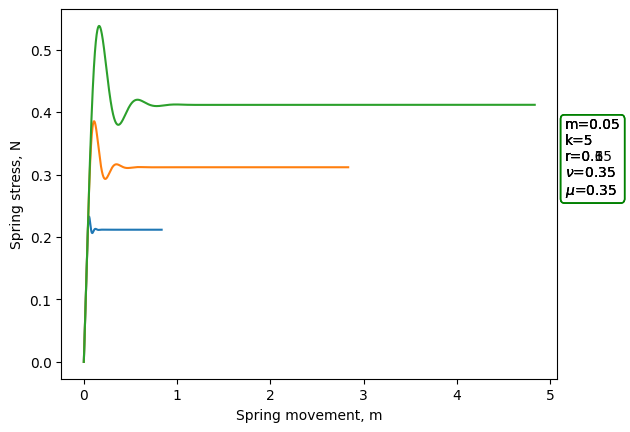

In [90]:
n = 4* 20

for r in np.linspace(1e-1, 6e-1, 3):
    param = {
    'm' : 50e-3, # kg
    'k' : 5, # N/m
    'r' : r, # m/s
    'mu' : 0.35,
    'nu' : 0.35,
    'gamma' : 0.2, # N / m/s
}

    s = setup(**param)
    s.plot_analogy(s.t0+n/s.omega0, noSave=True)

plt.savefig('output/analogy.jpg')

------------integrating parameters------------
t_stop = 20.057225 s, timeFinement = 100, dt = 0.001 s


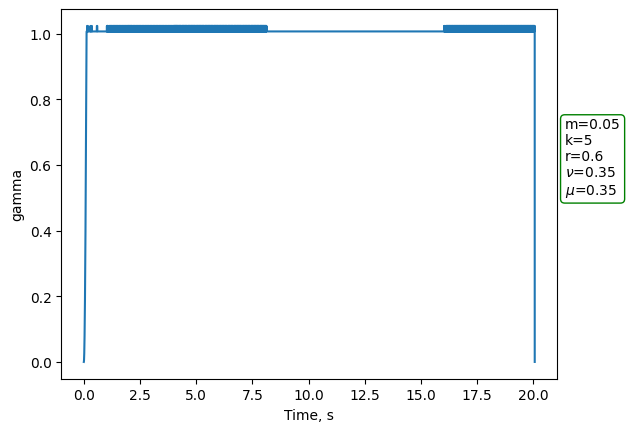

In [106]:
s.plot_gamma(s.t0+n/s.omega0, 0.12, noSave=True)

### Setting arbitrary parameters. Integrating the equation.

In [92]:
s1 = {
    'm' : 5, # kg
    'k' : 0.5, # N/m
    'r' : 2, # m/s
    'mu' : 1.4,
    'nu' : 1.5,
    'gamma' : 0.4, # N / m/s
}

setup1 = setup(**s1)

n = 4* 50

------------setup calculated parameters------------
drag start = 73.575 s, natural frequency = 0.31622776601683794 1/s


### Analogy illustration

------------integrating parameters------------
t_stop = 706.0305320336759 s, timeFinement = 100, dt = 0.03162277660168379 s


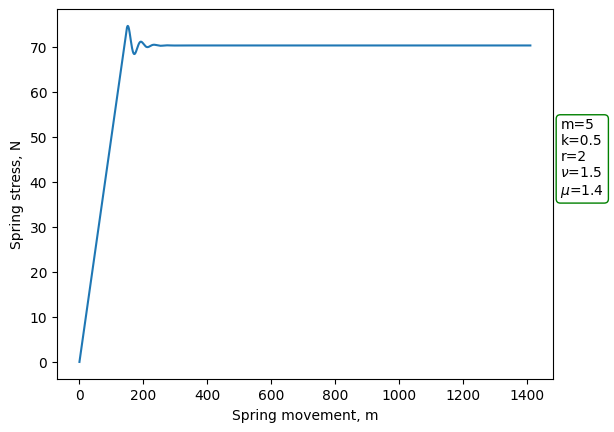

In [93]:
setup1.plot_analogy(setup1.t0+n/setup1.omega0, noSave=True)

### Motion illustrarion.

------------integrating parameters------------
t_stop = 706.0305320336759 s, timeFinement = 100, dt = 0.03162277660168379 s


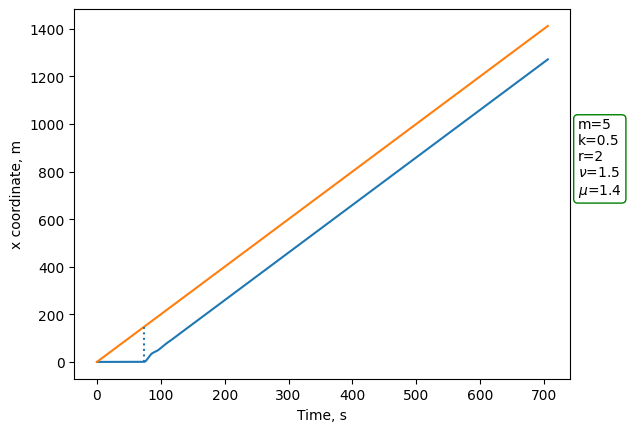

In [94]:
setup1.plot_motion(setup1.t0+n/setup1.omega0)

### Friction illustrarion.

------------integrating parameters------------
t_stop = 706.0305320336759 s, timeFinement = 100, dt = 0.03162277660168379 s


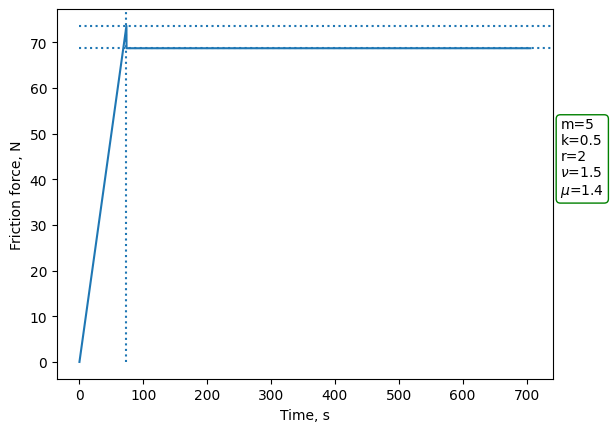

In [95]:
setup1.plot_friction(setup1.t0+n/setup1.omega0)

### Velocity illustration.

------------integrating parameters------------
t_stop = 706.0305320336759 s, timeFinement = 100, dt = 0.03162277660168379 s


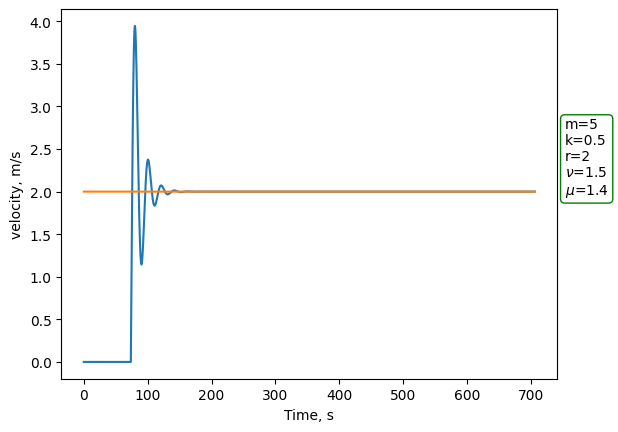

In [96]:
setup1.plot_velocity(setup1.t0+n/setup1.omega0)